In [41]:
import numpy as np
from numpy import linalg as la
import scipy
from scipy.linalg import expm
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp
import random
import time

SEED = 10
np.random.seed(SEED)
random.seed(SEED)

In [101]:
N = 20
p = .2

det_I = np.linalg.det(np.eye(N))
for i in range(5000):
    graph = nx.erdos_renyi_graph(N, p, directed=True)
    A = nx.to_numpy_array(graph)

    eigenvals, _ = np.linalg.eig(A)
    sorted_indices = np.argsort(np.abs(eigenvals))[::-1]  # Get the indices that would sort the eigenvalues
    eigenvals = np.real(eigenvals[sorted_indices])  # Sort the eigenvalues

    eps = np.random.uniform(.01, 1)
    A /= (eigenvals[0] + .1)

    det_B = np.linalg.det(np.eye(N) - A)

    assert det_B <= det_I, f'{i}: det_B is larger!!'
    assert det_B >= 0, f'{i}: det_B is negative!!'


Note: stepsize should be 1/Lipschitz constant

In [42]:
def create_dag(N, p):
    graph = nx.erdos_renyi_graph(N, p, directed=True)
    adjacency_matrix = nx.to_numpy_array(graph)
    adjacency_matrix = np.triu(adjacency_matrix, k=1)

    return adjacency_matrix


def DAG_no_tears_cvx(X, stepsize, rho, lamb, A_true, iters_o=10, iters_i=25):
    M, N = X.shape

    # Init A and alpha
    A_k = .1*np.ones((N,N))  # create_dag(N, .1)

    # print('Initial acyclicity:', np.trace(expm(A_k)))
    # print('Fidelity error:', 1/M*la.norm(X - X @ A_true, 'fro')**2)
    alpha_k = .01

    norm_A_true = la.norm(A_true)
    norms_A = np.zeros(iters_o)
    errs_A = np.zeros(iters_o)
    errs_X = np.zeros(iters_o)
    alphas_A = np.zeros(iters_o)
    acyclicity = np.zeros(iters_o)
    
    for i in range(iters_o):
        # Primal update
        Cx = X.T @ X
        for _ in range(iters_i):
            Gradient = 1 * Cx @(A_k - np.eye(N))
            Gradient += (alpha_k + rho*(np.trace(expm(A_k)) - N))*expm(A_k).T
            if np.any(np.isnan(Gradient)) or np.any(np.isinf(Gradient)):
                print('WARNING: gradient is NaN or Inf')
                break

            A_k = np.maximum(np.abs(A_k - stepsize*Gradient) - lamb, 0)

        for _ in range(iters_i):
            alpha_k = alpha_k + rho*(np.trace(expm(A_k)) - N)
            if np.any(np.isnan(alpha_k)) or np.any(np.isinf(alpha_k)):
                print(f'WARNING: alpha is NaN or Inf: {alpha_k}')
                break
        
        # norms_A[i] = la.norm(A_k)
        alphas_A[i] = alpha_k
        errs_A[i] = (la.norm(A_true - A_k)/norm_A_true)**2
        acyclicity[i] = np.trace(expm(A_k)) - N
        # errs_X[i] = 1/M*la.norm(X - X @ A_true, 'fro')**2

    return A_k, alphas_A, errs_A, acyclicity


def DAGMA_cvx(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
    M, N = X.shape

    # Init A
    mu_k = mu0
    A_k = np.zeros((N,N))
    Cx =  1 * X.T @ X

    norm_A_true = la.norm(A_true)
    errs_A = np.zeros(iters_o*iters_i)
    acyclicity = np.zeros(iters_o*iters_i)
    for i in range(iters_o):
        for j in range(iters_i):
            Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - A_k).T + lamb*np.ones_like(A_k)
            A_k = np.maximum(A_k - stepsize*Gradient, 0)
   
            idx = i*iters_i + j
            errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
            acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
        mu_k *= descount
    
    return A_k, errs_A, acyclicity


def DAGMA_cvx_neg(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
    M, N = X.shape

    # Init A
    mu_k = mu0
    A_k = np.zeros((N,N))
    Cx =  1 * X.T @ X

    norm_A_true = la.norm(A_true)
    errs_A = np.zeros(iters_o*iters_i)
    acyclicity = np.zeros(iters_o*iters_i)
    for i in range(iters_o):
        for j in range(iters_i):
            Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - np.abs(A_k)).T*np.sign(A_k)
            A_grad_step = A_k - stepsize*Gradient
            A_k = np.maximum(np.abs(A_grad_step) - lamb, 0) * np.sign(A_grad_step)
            # A_k = np.maximum(A_grad_step - lamb, 0)
   
            idx = i*iters_i + j
            errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
            acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
        mu_k *= descount
    
    return A_k, errs_A, acyclicity

## Assuming Possitive Weights 

In [43]:
# Create graph
p = .2
N = 20

A = create_dag(N, p)
dag = nx.from_numpy_array(A, create_using=nx.DiGraph())

assert nx.is_directed_acyclic_graph(dag), "Graph is not a DAG"

# Create Data
M = 500 #1000
noise_power = 0.05
Z = np.random.normal(loc=0, scale=np.sqrt(noise_power/N), size=(M, N))
# Model: X = XA - Z
X = Z @ la.inv(np.eye(N) - A)

print(la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


0.7882487055731481
Fidelity error: 0.04897304445754103


In [44]:
stepsize = .001
rho = .001
lamb = 1e-8
s = 1
mu0 = .8
eps = 1e-6

# Non-DAG constraints
t_i = time.time()
A_est = cp.Variable((N,N))
obj = cp.Minimize(cp.sum_squares(X - X @ A) + lamb * cp.sum(A_est))
const = [A_est >= 0, cp.diag(A_est) <= 0] # N*cp.log(s) - cp.log_det(s*np.eye(N) - A_est) <= 0

# ### Acyclicity as regularization ###
# obj = cp.Minimize(mu0 * cp.sum_squares(X - X @ A) + lamb * cp.sum(A_est) - cp.log_det(s*np.eye(N) - A_est))
# const = [A_est >= 0, cp.diag(A_est) <= eps, N*cp.log(s) - cp.log_det(s*np.eye(N) - A_est) <= 0]

prob = cp.Problem(obj, const)
prob.solve(verbose=False)
A_cvx = A_est.value
t_solved = time.time() - t_i
print(f'CVX {prob.status} in {t_solved:3f} seconds')

t_i = time.time()
A_dag, alphas_A, errs_A, acyclicity = DAG_no_tears_cvx(X, stepsize, rho, lamb, A, iters_o=500, iters_i=25)
t_solved = time.time() - t_i
print(f'No TEARS solved in {t_solved:3f} seconds')

## First set of hyperparams
# stepsize2 = 1e-3
# mu0 = 1
# descount = .9
# s = 1
# lamb2 = 1e-8

## Second set of hyperparams
stepsize2 = 1e-3
mu0 = .8
descount = .9
s = 1
lamb2 = 1e-8

t_i = time.time()
A_dagma, errs_A_dagma, acyclicity_dagma = DAGMA_cvx(X, stepsize2, mu0, descount, s, lamb2, A, iters_o=1, iters_i=4*10000)
t_solved = time.time() - t_i
print(f'DAGMA solved in {t_solved:3f} seconds')

stepsize2 = 1e-3
mu0 = .2
descount = .9
s = 1
lamb2 = 1e-5

t_i = time.time()
A_dagma_n, errs_A_dagma_n, acyclicity_dagma_n = DAGMA_cvx_neg(X, stepsize2, mu0, descount, s, lamb2, A, iters_o=1, iters_i=10*10000)
t_solved = time.time() - t_i
print(f'DAGMA (negative) solved in {t_solved:3f} seconds')


CVX optimal in 0.015734 seconds
No TEARS solved in 8.468900 seconds
DAGMA solved in 3.531709 seconds
DAGMA (negative) solved in 8.632389 seconds


Square fro err (no tears)): 0.008
Square fro err (dagma): 0.005
Square fro err (dagma neg): 0.009


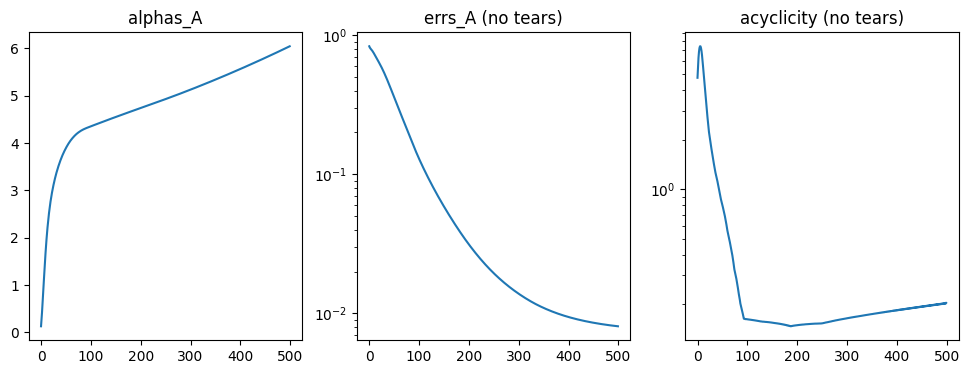

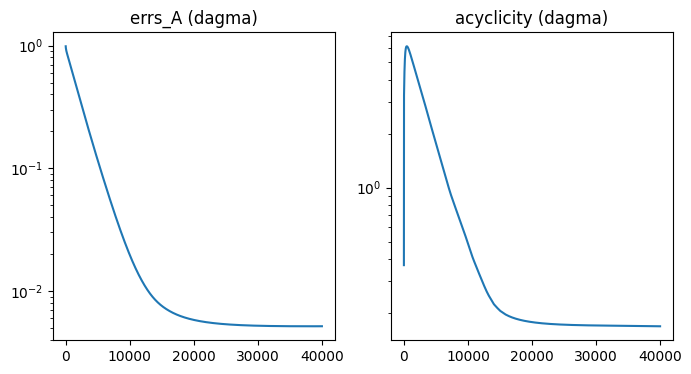

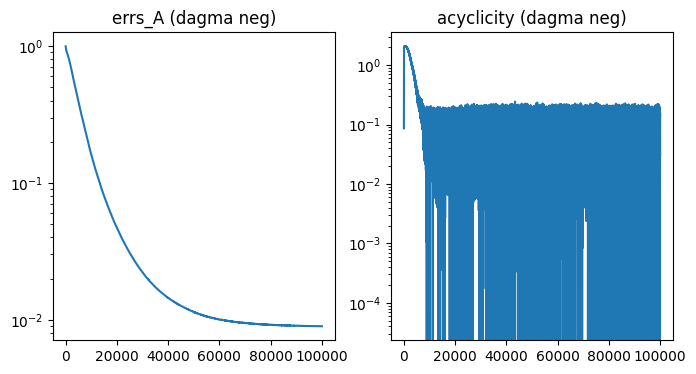

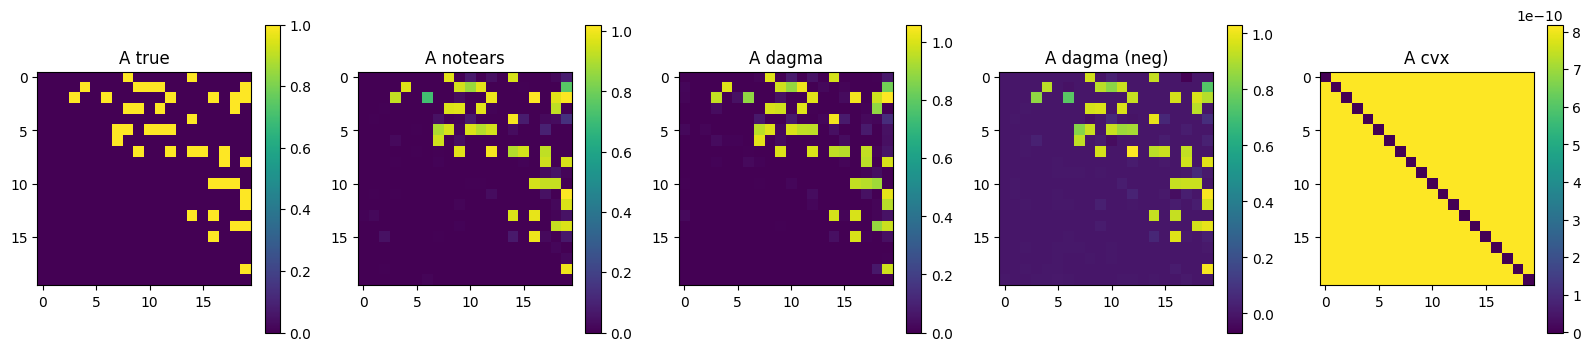

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(alphas_A)
plt.title('alphas_A')
plt.subplot(1,3,2)
plt.semilogy(errs_A)
plt.title('errs_A (no tears)')
plt.subplot(1,3,3)
plt.semilogy(acyclicity)
plt.title('acyclicity (no tears)')
print(f'Square fro err (no tears)): {errs_A[-1]:.3f}')

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.semilogy(errs_A_dagma)
plt.title('errs_A (dagma)')
plt.subplot(1,2,2)
plt.semilogy(acyclicity_dagma)
plt.title('acyclicity (dagma)')
print(f'Square fro err (dagma): {errs_A_dagma[-1]:.3f}')

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.semilogy(errs_A_dagma_n)
plt.title('errs_A (dagma neg)')
plt.subplot(1,2,2)
plt.semilogy(acyclicity_dagma_n)
plt.title('acyclicity (dagma neg)')
print(f'Square fro err (dagma neg): {errs_A_dagma_n[-1]:.3f}')

plt.figure(figsize=(20, 4))
plt.subplot(1,5,1)
plt.imshow(A)
plt.colorbar()
plt.title("A true")
plt.subplot(1,5,2)
plt.imshow(A_dag)
plt.colorbar()
plt.title("A notears")
plt.subplot(1,5,3)
plt.imshow(A_dagma)
plt.colorbar()
plt.title("A dagma")
plt.subplot(1,5,4)
plt.imshow(A_dagma_n)
plt.colorbar()
plt.title("A dagma (neg)")
plt.subplot(1,5,5)
plt.imshow(A_cvx)
plt.colorbar()
plt.title("A cvx")
plt.show()

## With Negative and Possitive Weights 

In [46]:
# Create graph
p = .2
N = 20

A = create_dag(N, p)
A = A* (np.ones((N,N)) + (np.random.rand(N,N) > .5)*-2)
dag = nx.from_numpy_array(A, create_using=nx.DiGraph())

assert nx.is_directed_acyclic_graph(dag), "Graph is not a DAG"

# Create Data
M = 500
noise_power = 0.05
Z = np.random.normal(loc=0, scale=np.sqrt(noise_power/N), size=(M, N))
X = Z @ la.inv(np.eye(N) - A)

print(la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)

0.5051331605176861
Fidelity error: 0.05069855575701755


In [47]:
stepsize = .001
rho = .001
lamb = 1e-8

t_i = time.time()
A_dag, alphas_A, errs_A, acyclicity = DAG_no_tears_cvx(X, stepsize, rho, lamb, A, iters_o=500, iters_i=25)
t_solved = time.time() - t_i
print(f'No TEARS solved in {t_solved:3f} seconds')

# Second set of hyperparams
stepsize2 = 1e-3
mu0 = .8
descount = .9
s = 1
lamb2 = 1e-8

t_i = time.time()
A_dagma, errs_A_dagma, acyclicity_dagma = DAGMA_cvx(X, stepsize2, mu0, descount, s, lamb2, A, iters_o=1, iters_i=4*10000)
t_solved = time.time() - t_i
print(f'DAGMA solved in {t_solved:3f} seconds')

stepsize2 = 1e-3
mu0 = .2
descount = .9
s = 1
lamb2 = 1e-5

t_i = time.time()
A_dagma_n, errs_A_dagma_n, acyclicity_dagma_n = DAGMA_cvx_neg(X, stepsize2, mu0, descount, s, lamb2, A, iters_o=1, iters_i=10*10000)
t_solved = time.time() - t_i
print(f'DAGMA (negative) solved in {t_solved:3f} seconds')


No TEARS solved in 9.344868 seconds
DAGMA solved in 3.736909 seconds
DAGMA (negative) solved in 9.304557 seconds


Square fro err (no tears)): 0.979
Square fro err (dagma): 1.125
Square fro err (dagma neg): 0.031


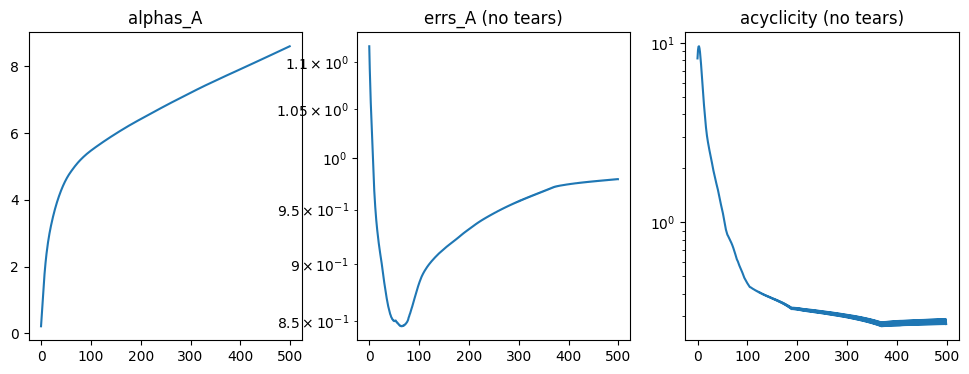

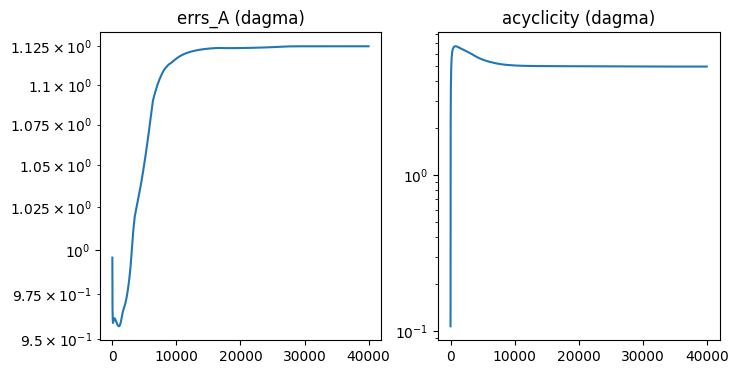

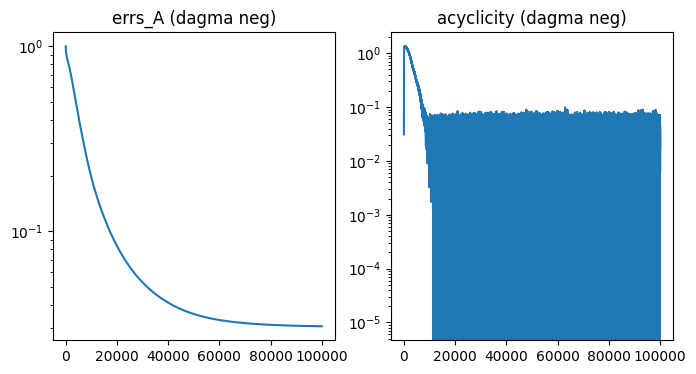

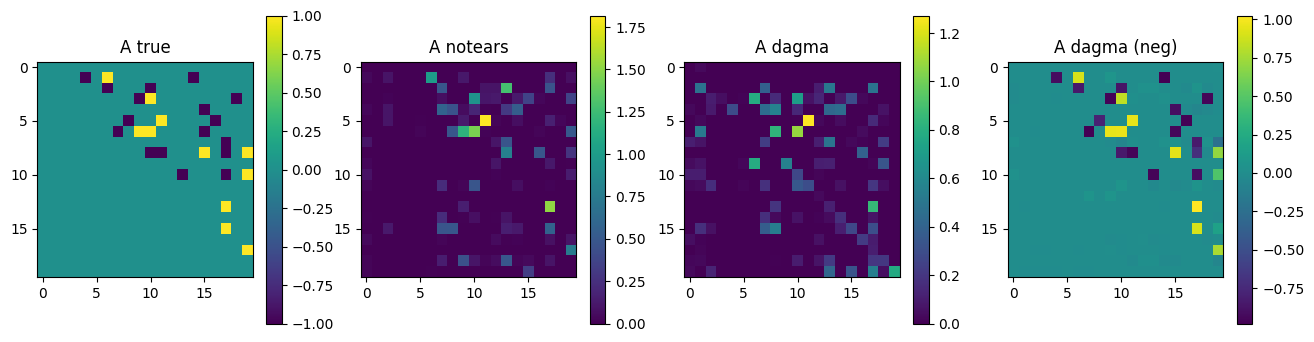

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.plot(alphas_A)
plt.title('alphas_A')
plt.subplot(1,3,2)
plt.semilogy(errs_A)
plt.title('errs_A (no tears)')
plt.subplot(1,3,3)
plt.semilogy(acyclicity)
plt.title('acyclicity (no tears)')
print(f'Square fro err (no tears)): {errs_A[-1]:.3f}')

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.semilogy(errs_A_dagma)
plt.title('errs_A (dagma)')
plt.subplot(1,2,2)
plt.semilogy(acyclicity_dagma)
plt.title('acyclicity (dagma)')
print(f'Square fro err (dagma): {errs_A_dagma[-1]:.3f}')

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.semilogy(errs_A_dagma_n)
plt.title('errs_A (dagma neg)')
plt.subplot(1,2,2)
plt.semilogy(acyclicity_dagma_n)
plt.title('acyclicity (dagma neg)')
print(f'Square fro err (dagma neg): {errs_A_dagma_n[-1]:.3f}')


plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.imshow(A)
plt.colorbar()
plt.title("A true")
plt.subplot(1,4,2)
plt.imshow(A_dag)
plt.colorbar()
plt.title("A notears")
plt.subplot(1,4,3)
plt.imshow(A_dagma)
plt.colorbar()
plt.title("A dagma")
plt.subplot(1,4,4)
plt.imshow(A_dagma_n)
plt.colorbar()
plt.title("A dagma (neg)")
plt.show()